In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy.stats as stats
import random

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV


Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [2]:
data = pd.read_csv("train.csv")
data.head()

Artist Name                             Track Name  Popularity  \
0             Bruno Mars  That's What I Like (feat. Gucci Mane)        60.0   
1                 Boston                           Hitch a Ride        54.0   
2          The Raincoats                     No Side to Fall In        35.0   
3                   Deno             Lingo (feat. J.I & Chunkz)        66.0   
4  Red Hot Chili Peppers      Nobody Weird Like Me - Remastered        53.0   

   danceability  energy   key  loudness  mode  speechiness  acousticness  \
0         0.854   0.564   1.0    -4.964     1       0.0485      0.017100   
1         0.382   0.814   3.0    -7.230     1       0.0406      0.001100   
2         0.434   0.614   6.0    -8.334     1       0.0525      0.486000   
3         0.853   0.597  10.0    -6.528     0       0.0555      0.021200   
4         0.167   0.975   2.0    -4.279     1       0.2160      0.000169   

   instrumentalness  liveness  valence    tempo  duration_in min/ms  \
0               NaN    0.0849   0.8990  134.071            234596.0   
1          0.004010    0.1010   0.5690  116.454            251733.0   
2          0.000196    0.3940   0.7870  147.681            109667.0   
3               NaN    0.1220   0.5690  107.033            173968.0   
4          0.016100    0.1720   0.0918  199.060            229960.0   

   time_signature  Class  
0               4      5  
1               4     10  
2               4      6  
3               4      5  
4               4     10

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

Видим, что в датасете содержится 17996 песен, описанных по 17-ти признакам.

Посмотрим, какие параметры у нас являются категориальными, для этого подсчитаем количество уникальных значений:

In [4]:
for col in data.columns:
    print(f'{col} has _{data[col].nunique()}_ unique values')

Artist Name has _9149_ unique values
Track Name has _15129_ unique values
Popularity has _100_ unique values
danceability has _909_ unique values
energy has _1208_ unique values
key has _11_ unique values
loudness has _9002_ unique values
mode has _2_ unique values
speechiness has _1194_ unique values
acousticness has _3930_ unique values
instrumentalness has _4253_ unique values
liveness has _1459_ unique values
valence has _1320_ unique values
tempo has _13562_ unique values
duration_in min/ms has _14121_ unique values
time_signature has _4_ unique values
Class has _11_ unique values


Очевидно, что такие свойства как *Artist Name* и *Track Name* будут иметь слабую предсказательную силу из-за большего количества значений в них и по причинам, которые подсказывает здравый смысл.
Мы можем выделить ряд количественных и качественных признаков.     

**Количественные:**     
*Popularity* - популярность песни      
*danceability* - можно ли танцевать под песню     
*energy* - энергичность      
*loudness* - громкость      
*speechiness* - видимо, метрика качества/количества текста    
*acousticness* - использование акустики      
*instrumentalness* - инструментальность     
*liveness* - живость     
*valence* - позитивность       
*tempo* - метрика  скорости     
*duration_in min/ms* - длительность   

**Качественные:**     
*key* - тональность    
*mode* - лад     
*time_signature* - размер такта     
*Class* - непосредственно жанр, наша целевая переменная   

Поищем пропущенные значения в наших данных:

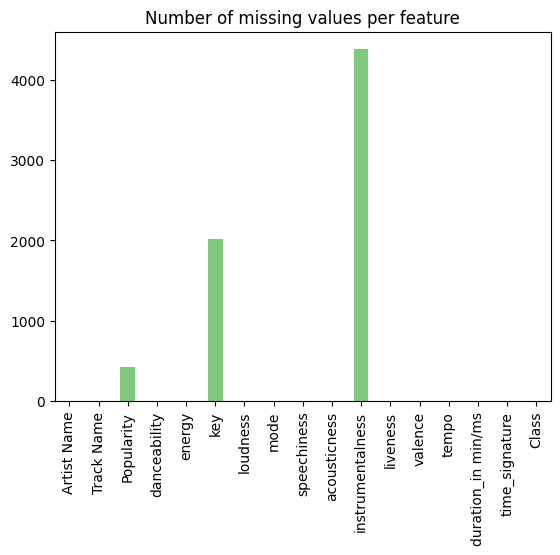

In [5]:
data.isna().sum().plot(kind="bar", colormap = 'Accent', title="Number of missing values per feature")
plt.show()

Мы видим, что некоторые свойства имеют большое количество пропущенных значений. Кажется, что присвоение значениям, *instrumentalness* и *key*, например, медианного значения или самого распространенного может довольно сильно испортить работу нашего дерева, поэтому удалим эти наблюдения. Что касается *popularity*, nan здесь немного, присвоим им медианное значение.

In [6]:
data['Popularity'] = data['Popularity'].fillna(data['Popularity'].median())

data_clean = data.dropna()
data_clean.isna().sum()

Artist Name           0
Track Name            0
Popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
time_signature        0
Class                 0
dtype: int64

Посмотрим на баланс классов:

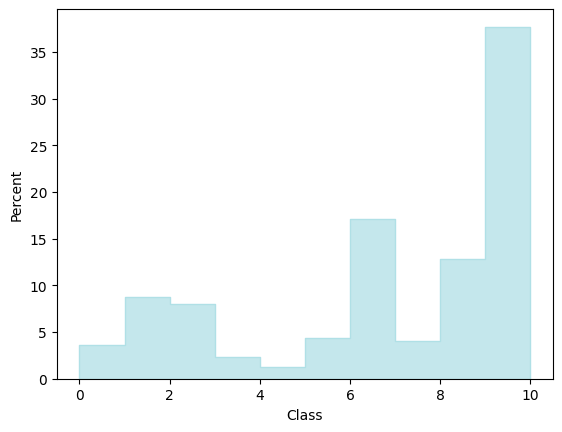

In [7]:
sns.histplot(data_clean['Class'], stat = 'percent', binwidth = 1,  color = "powderblue", element="step")
plt.show()

Видим, что классы в данных не сбалансированы, и среди жанров музыки преобладает рок.

Посмотрим на распределение других качественных признаков:

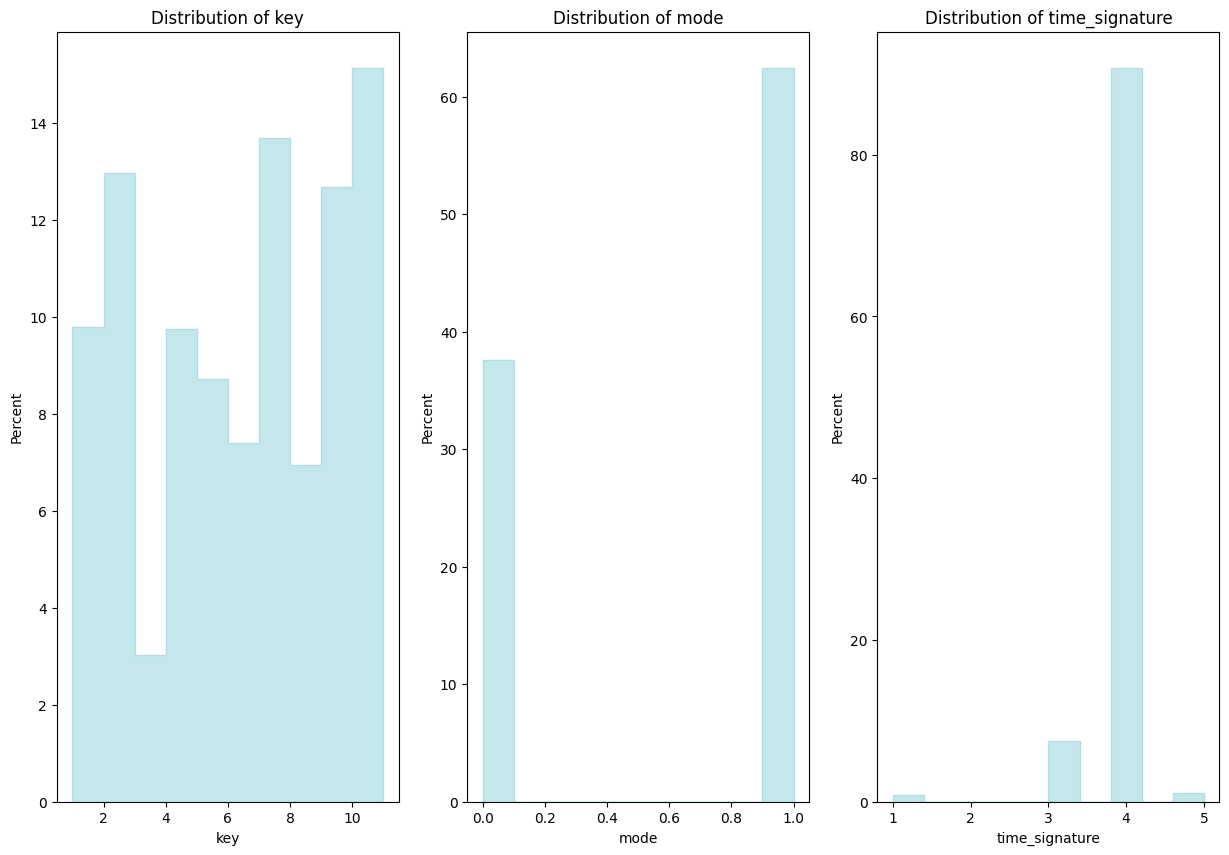

In [8]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(['key', 'mode', 'time_signature']):
    plt.subplot(1, 3, i+1)
    sns.histplot(data_clean[column], bins=10, element="step", stat = 'percent', color='powderblue')
    plt.title(f'Distribution of {column}')

Видим, что тональности представлены относительно равномерно, в ладах есть некоторый перекос в сторону мажорного, а вот среди тактов безоговорочно преобладают 4-ки.

Посмотрим на распределение значений в количественных столбцах, а также поищем выбросы.

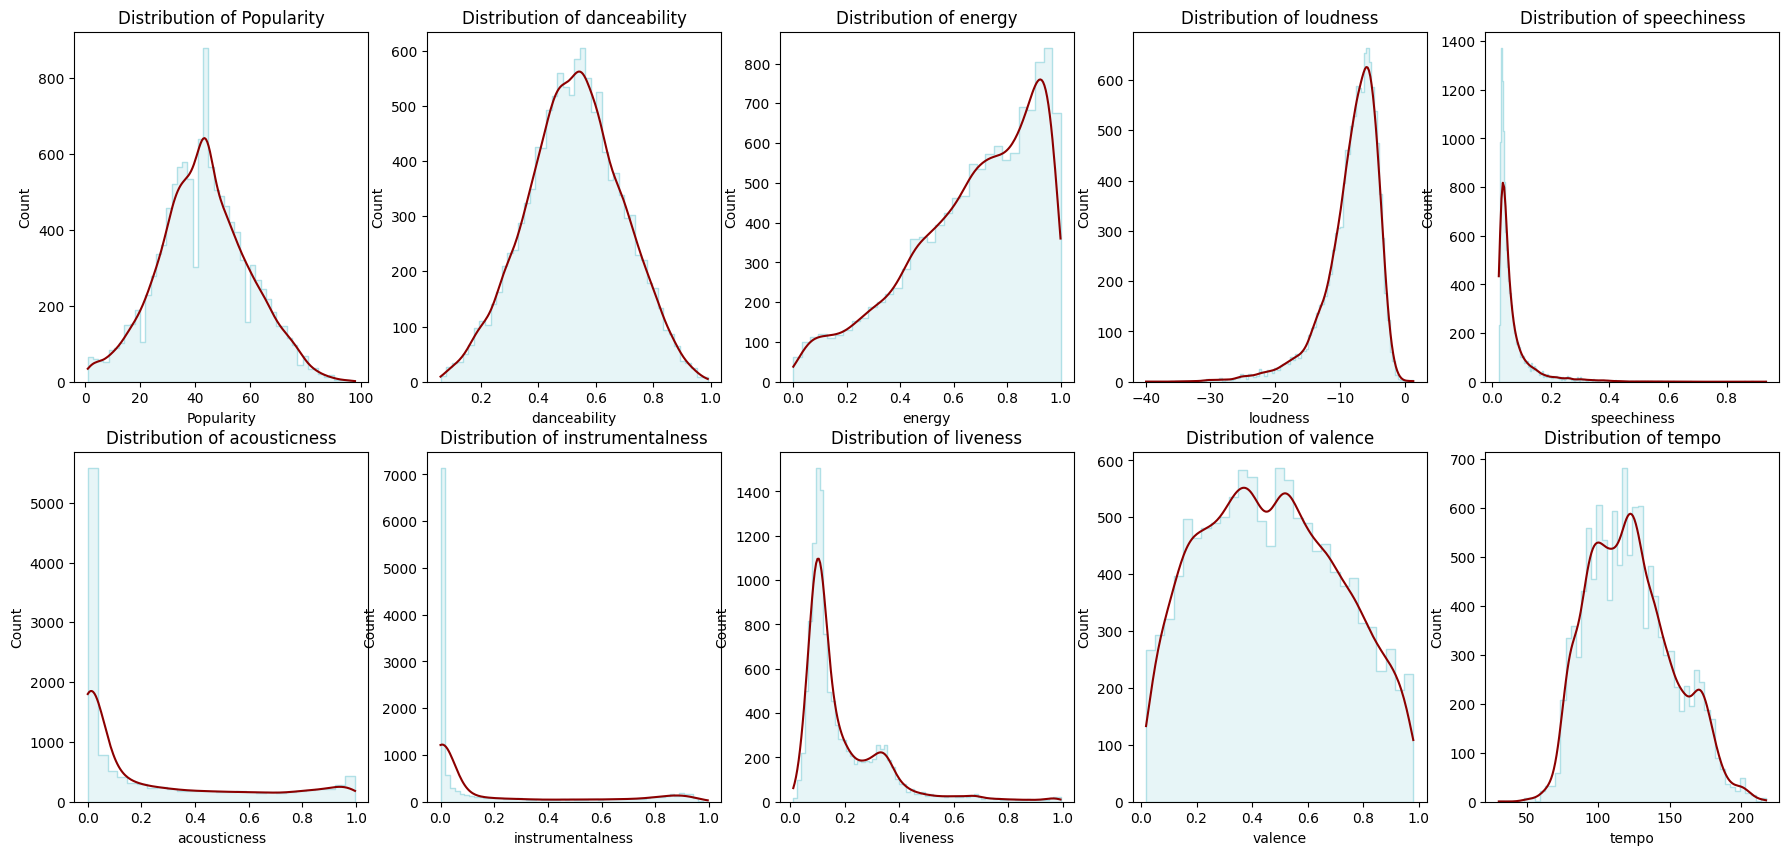

In [9]:
num_columns = ['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(22, 10))
for i, column in enumerate(num_columns):
    plt.subplot(2, 5, i+1)
    sns.histplot(data_clean[column], color='powderblue',element="step", alpha=0.3, kde = True).lines[0].set_color('darkred')
    plt.title(f'Distribution of {column}')

Что-то похожее на нормальное распределение имеют *Popularity* и *danceability*, кажется, что *valence* и *tempo* распределены бимодально, а остальные унимодальные, но скошенные.


Отдельно посмотрим на *duration_in min/ms*:

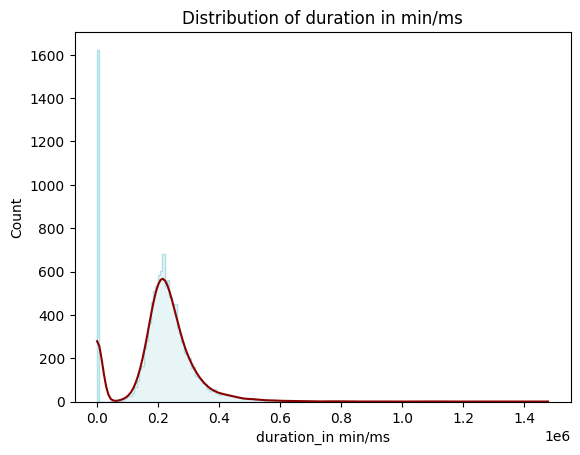

In [10]:
sns.histplot(data_clean['duration_in min/ms'], color='powderblue',element="step", alpha=0.3, kde = True).lines[0].set_color('darkred')
plt.title(f'Distribution of duration in min/ms')
plt.show()

Распределение кажется очень странным, и не просто так: длительность некоторых песен записана в минутах, других - в миллисекундах.

In [11]:
data_clean['duration_in min/ms'][data_clean['duration_in min/ms'] < 100]
data_clean['duration_in min/ms'][data_clean['duration_in min/ms'] > 10000]

1        251733.0
2        109667.0
4        229960.0
5        208133.0
6        329387.0
           ...   
17991    193450.0
17992    257067.0
17993    216222.0
17994    219693.0
17995    182227.0
Name: duration_in min/ms, Length: 10464, dtype: float64

Исправим это и переименуем столбец:

In [12]:
data_clean['duration_in min/ms'] = data_clean['duration_in min/ms'].apply(lambda x: x*60000 if x < 100 else x)
data_clean['duration'] = data_clean['duration_in min/ms']
data_clean = data_clean.drop(columns=['duration_in min/ms'])

data_clean.head()

C:\Users\kiit8\AppData\Local\Temp\ipykernel_15404\2945949749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['duration_in min/ms'] = data_clean['duration_in min/ms'].apply(lambda x: x*60000 if x < 100 else x)
C:\Users\kiit8\AppData\Local\Temp\ipykernel_15404\2945949749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['duration'] = data_clean['duration_in min/ms']


Artist Name                         Track Name  Popularity  \
1                 Boston                       Hitch a Ride        54.0   
2          The Raincoats                 No Side to Fall In        35.0   
4  Red Hot Chili Peppers  Nobody Weird Like Me - Remastered        53.0   
5            The Stooges  Search and Destroy - Iggy Pop Mix        53.0   
6          Solomon Burke                None Of Us Are Free        48.0   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
1         0.382   0.814  3.0    -7.230     1       0.0406      0.001100   
2         0.434   0.614  6.0    -8.334     1       0.0525      0.486000   
4         0.167   0.975  2.0    -4.279     1       0.2160      0.000169   
5         0.235   0.977  6.0     0.878     1       0.1070      0.003530   
6         0.674   0.658  5.0    -9.647     0       0.1040      0.404000   

   instrumentalness  liveness  valence    tempo  time_signature  Class  \
1          0.004010    0.1010   0.5690  116.454               4     10   
2          0.000196    0.3940   0.7870  147.681               4      6   
4          0.016100    0.1720   0.0918  199.060               4     10   
5          0.006040    0.1720   0.2410  152.952               4      6   
6          0.000001    0.0981   0.6770  143.292               4      2   

   duration  
1  251733.0  
2  109667.0  
4  229960.0  
5  208133.0  
6  329387.0

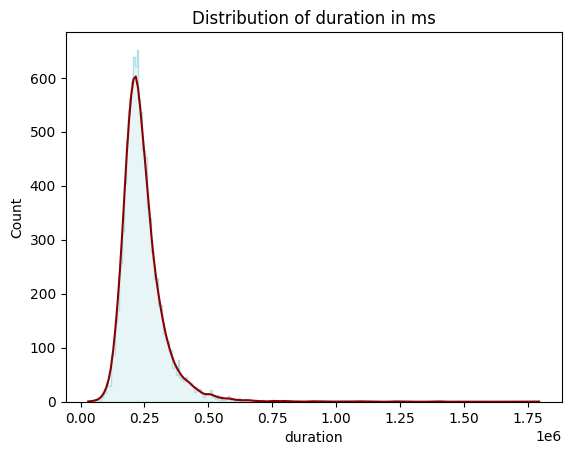

In [13]:
sns.histplot(data_clean['duration'], color='powderblue',element="step", alpha=0.3, kde = True).lines[0].set_color('darkred')
plt.title(f'Distribution of duration in ms')
plt.show()

Теперь распределение выглядит лучше.

Займемся поиском выбросов:

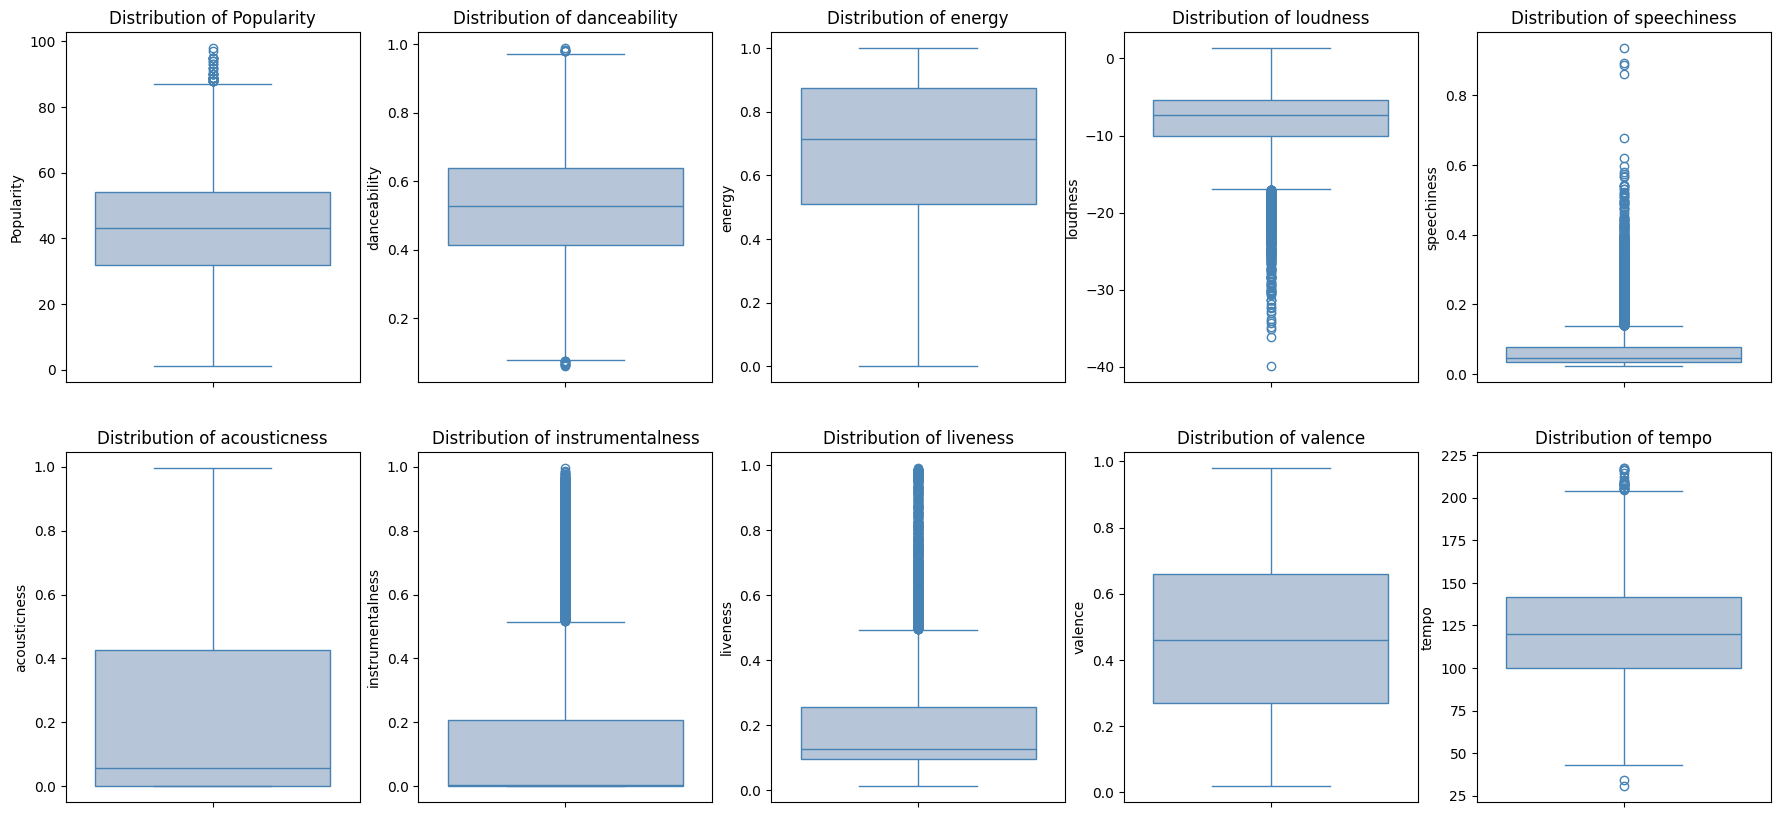

In [14]:
plt.figure(figsize=(22, 10))
for i, column in enumerate(num_columns):
    plt.subplot(2, 5, i+1)
    sns.boxplot(data_clean[column], color='lightsteelblue', linecolor="steelblue",)
    plt.title(f'Distribution of {column}')

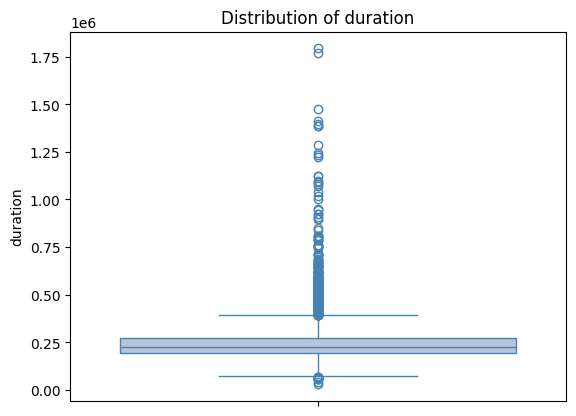

In [15]:
sns.boxplot(data_clean['duration'], color='lightsteelblue', linecolor="steelblue",)
plt.title(f'Distribution of duration')
plt.show()

In [16]:
data_clean.shape

(12088, 17)

Выбрасы есть во всех признаках, кроме *acousticness* и *valence*. Удалим выбросы для лучшей работы модели.

In [17]:
data_clean = data_clean.drop(columns=['Artist Name', 'Track Name'])

z = np.abs(stats.zscore(data_clean))
data_clean = data_clean[(z<3).all(axis=1)]

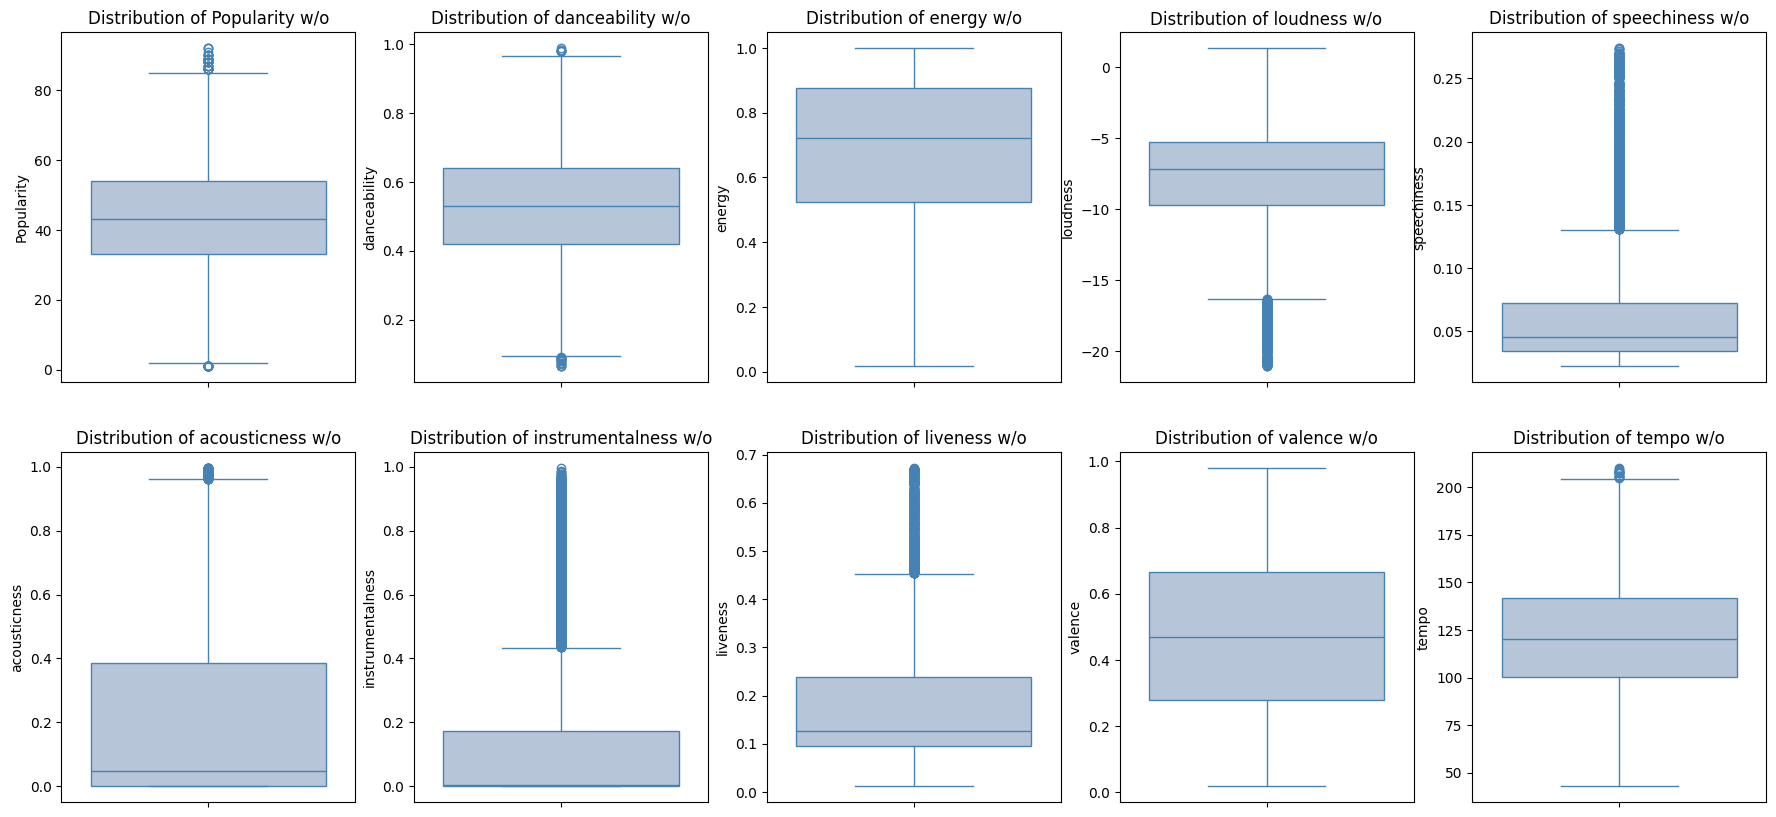

In [18]:
plt.figure(figsize=(22, 10))
for i, column in enumerate(num_columns):
    plt.subplot(2, 5, i+1)
    sns.boxplot(data_clean[column], color='lightsteelblue', linecolor="steelblue",)
    plt.title(f'Distribution of {column} w/o')
plt.show()

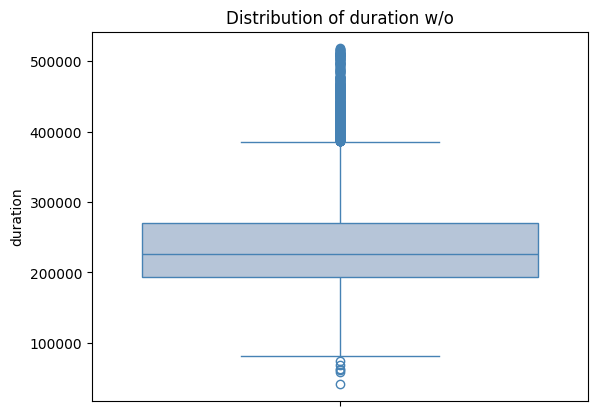

In [19]:
sns.boxplot(data_clean['duration'], color='lightsteelblue', linecolor="steelblue",)
plt.title(f'Distribution of duration w/o')
plt.show()

In [20]:
data_clean.shape

(11015, 15)

*loudness*, *speechiness* и *duration* заметно изменились.

Узнаем также, существует ли корреляция между признаками.

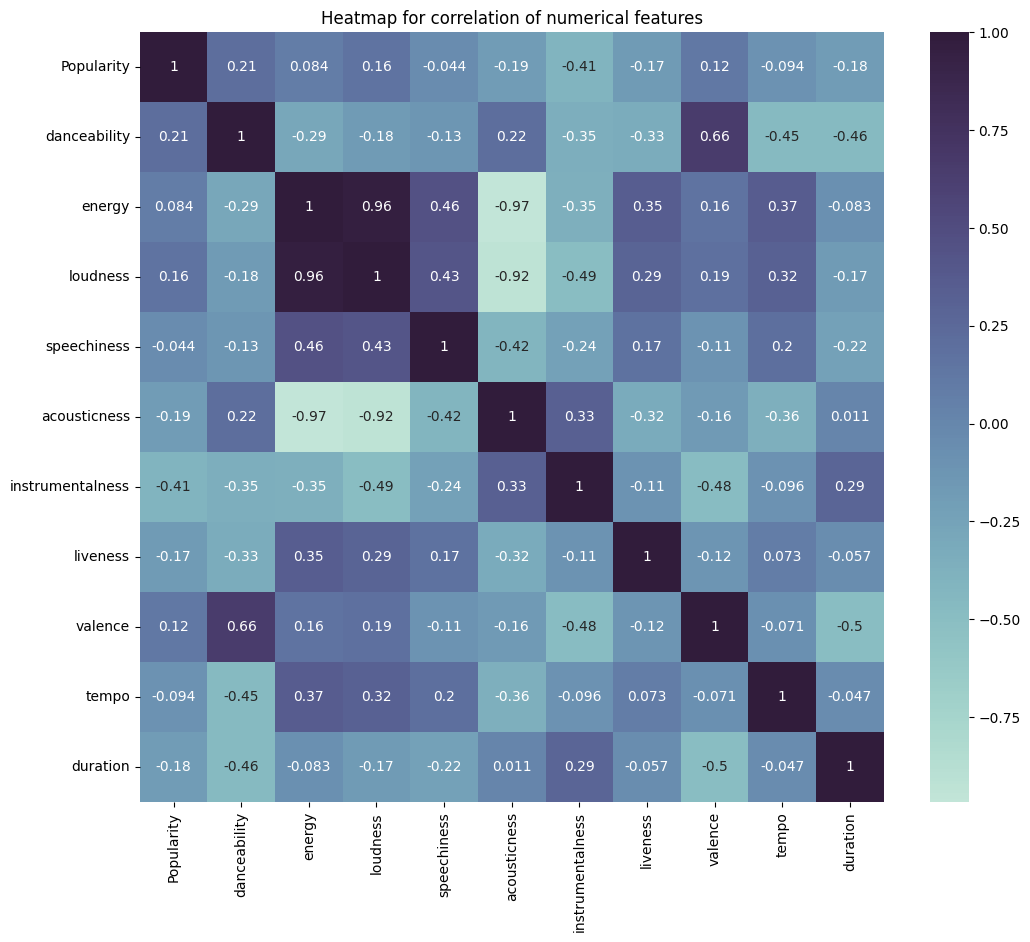

In [21]:
numerical_features = pd.concat((data_clean[num_columns], data_clean['duration']), axis = 1).corr()
corr_matrix = numerical_features.corr()

plt.figure(figsize=(12, 10))
cub = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
sns.heatmap(corr_matrix, annot = True, cmap = cub)
plt.title('Heatmap for correlation of numerical features')
plt.show()

Как видно из графика, есть сильная прямая связь между такими свойствами, как *loudness* и *energy* (энергичная музыка обычно громче), и сильная обратная корреляция между *energy* и *acousticness* (акустическая музыка, как правило, менее энергичная), а также *acousticness* и *loudness* (акустическая музыка, как правило, тише).      
Менее сильная положительная корреляция существует между *valence* и *danceability* (танцевальная музыка более жизнеутверждающая).    

Обнаруженную корреляцию учтём на будущее. 

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [22]:
SEED = 111
random.seed(SEED)
np.random.seed(SEED)

In [23]:
X = data_clean.drop(columns=['Class'])
y = data_clean['Class']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [25]:
numerical_features = list(numerical_features.columns)

In [26]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), numerical_features)
])

In [27]:
X_train = preprocessor.fit_transform(X_train)

In [28]:
params= {'max_depth': [5, 7, 15, 20, 50], 
              'min_samples_leaf': [2, 3, 5, 7, 10, 15, 20], 
              'min_samples_split': [2, 3, 5, 7, 10, 15],
              'criterion': ['gini', 'entropy'],
              'splitter': ["best", "random"]}

dtc = DecisionTreeClassifier()
grid_search = GridSearchCV(dtc, params, scoring='accuracy', cv=5)

In [29]:
grid_search.fit(X_train, y_train)

print("Best accuracy:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)

Best accuracy: 0.40090791180285346
Best parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 2, 'splitter': 'best'}


Что ж, остановимся на 40%.

Визуализируем получившееся дерево:

In [30]:
final_model = grid_search.best_estimator_
class_names = y.unique().astype(str)

fig = plt.figure(figsize=(250, 250))
plot_tree(final_model, feature_names=X.columns, class_names=class_names, fontsize=6, filled=True)
plt.show()
fig.savefig("decistion_tree.png")

Ради забавы отрисуем дерево псевдографикой:

In [31]:
text_representation = export_text(final_model)
print(text_representation)

|--- feature_5 <= -0.61
|   |--- feature_1 <= 0.74
|   |   |--- feature_2 <= 1.06
|   |   |   |--- feature_8 <= -0.27
|   |   |   |   |--- feature_5 <= -0.73
|   |   |   |   |   |--- feature_10 <= 0.22
|   |   |   |   |   |   |--- feature_4 <= -0.46
|   |   |   |   |   |   |   |--- class: 10
|   |   |   |   |   |   |--- feature_4 >  -0.46
|   |   |   |   |   |   |   |--- class: 10
|   |   |   |   |   |--- feature_10 >  0.22
|   |   |   |   |   |   |--- feature_2 <= 0.42
|   |   |   |   |   |   |   |--- class: 10
|   |   |   |   |   |   |--- feature_2 >  0.42
|   |   |   |   |   |   |   |--- class: 8
|   |   |   |   |--- feature_5 >  -0.73
|   |   |   |   |   |--- feature_6 <= -0.57
|   |   |   |   |   |   |--- feature_4 <= 0.08
|   |   |   |   |   |   |   |--- class: 10
|   |   |   |   |   |   |--- feature_4 >  0.08
|   |   |   |   |   |   |   |--- class: 10
|   |   |   |   |   |--- feature_6 >  -0.57
|   |   |   |   |   |   |--- feature_10 <= -0.24
|   |   |   |   |   |   |   |--- cla

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1.**Пленницы** (реж. Дени Вельнёв) - очень нравится атмосфера туманного пригорода, дождя и неона. Дени - прекрасный режиссер, который не только способен создать красивую картинку, но и заставить её работать на раскрытие сюжета, персонажей и погружение зрителя в особое, немного трансоподобное, настроение. Для меня в этом фильме хорошо всё: крепкий детективный сюжет, наикрутейший каст, где каждый из актёров отыгрывает на 1000%, и, конечно же, возможность открывать новые детали при повторных просмотрах. 

2.**Стрингер** (реж.Дэн Гилрой) - по моему мнению, один из лучших неонуаров. 

3.**Дорога на Эльдорадо** (мультфильм) - один из любимых мультиков детства. Диск с ним засмотрела до дыр. Прекрасная музыка Элтона Джона, атмосфера приключения, интересные персонажи.